# Utilizing the HTAN ID Provenance Google BigQuery Table


```
Title:   Utilizing the HTAN ID Provenance Google BigQuery Table
Author:  Clarisse Lau & Dar'ya Pozhidayeva
Created: 2023-04-18
Updated: 2025-06-09
Purpose: Introduce and illustrate example use cases for the HTAN 'ID Provenance' BigQuery Table.
```


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/HTAN_ID_Provenance_In_BQ.ipynb)

# 1. Introduction & Overview
The Human Tumor Atlas Network (HTAN) is a National Cancer Institute (NCI)-funded Cancer Moonshot<sup>SM</sup> initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease ( [Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469) ) More information about the project can be found on [the HTAN Data Portal](https://humantumoratlas.org/).






In this notebook, we will explore the HTAN ID Provenance BigQuery Table. In this context, provenance refers to the lineage of HTAN identifiers from participant to biospecimen to data file. The motivation for constructing the table arose from the need for a straightforward method of showcasing how HTAN data files are linked to biospecimens and patients.

Although this information is available in HTAN, connections among assay file levels and parent relationships (both biospecimen and file) do not exist in a singular location and can only be identified through table joining. Therefore, having all ID information in one place can significantly speed up analyses, exploration, and data sharing.

### 1.1 Notebook Goal

In this notebook, we will introduce the HTAN ID provenance BigQuery table, demonstrate how it can be accessed via Python, and provide a few examples for how users can utilize this table to integrate HTAN data files with upstream biospecimen and participant info through HTAN IDs.


### 1.2 Inputs, Outputs, & Data

The input for this notebook is the publicly available ID provenance BigQuery table, located at `isb-cgc-bq.HTAN.id_provenance_current`

The provenance table is constructed using biospecimen and file metadata manifests available on the HTAN Data Portal.


### 1.3 Notes
The queries and results in this notebook correspond to ISB-CGC's most current HTAN Release.

To choose a specific release, edit the BigQuery table names in this notebook by replacing the relevant string endings:
- `current` with a selected numbered release, e.g., `r2`
- `HTAN` with `HTAN_versioned`
- `gc` with `cds` (if applicable)

#
### ⚠️PAUSE
Notebooks associated with ISB-CGC HTAN Releases 6.0 or earlier are based on the **HTAN Phase 1 Data Model**. Please be aware that the structure, terminology, and available data elements may differ from those in Phase 2. 

# 2. Environment & Module Setup
The libraries used in this analysis fall into two categories: those needed for google cloud connection and those needed for the analysis itself.

In [1]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see [Quick Start Guide to ISB-CGC](https://nbviewer.org/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/Quick_Start_Guide_to_ISB_CGC.ipynb) and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

## 3.1 Authenticating with Google Credentials

#### Option 1. Running in Google Colab

If you are using Google Colab, run the code block below to authenticate.

In [ ]:
auth.authenticate_user()

#### Option 2. Running on local machine

Alternatively, if you're running the notebook locally, take the following steps to authenticate.

1.   Run `gcloud auth application-default login` on your local machine
2.   Run the command below replacing `<path to key>` with the path to your credentials file

In [ ]:
# env GOOGLE_APPLICATION_CREDENTIALS='<path to key>'

## 3.2 Initializing the Google BigQuery client

In [2]:
# Set the Google project that will be billed for this notebook's computations
# Replace <my-project> with your BigQuery Project ID
google_project = '<my-project>'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

# 4. ID Provenance in HTAN



## 4.1 HTAN Definitions

### 4.1.1 HTAN Identifiers
All research participants, biospecimens and derived data within HTAN are assigned unique HTAN identifiers. These are are constructed using the following patterns: 

* **<< participant_id >> ::= << htan_center_id >>_integer** (e.g. HTA1_203)

* **<< derivative_entity_id >>	::= << participant_id >>_integer** (e.g. HTA1_203_332)

See the [Identifiers page](https://docs.humantumoratlas.org/data_model/identifiers/) of the HTAN Missing Manual for a full breakdown of HTAN ID formats. 



In HTAN, linked relationships are represented by providing the "parent" at each level. For example, a participant ID is the "parent" of a biospecimen sample "child." Additionally, biospecimen samples can have one or more "children" if the participant or sample is sub-sampled one or more times (*see complex biospecimen path in Figure 1.*).

### 4.1.2 Biospecimen Attribute Definitions

Given the complexity of biospecimen relationships, we've adopted the following nomenclature to describe biospecimen lineages:

* **Originating Biospecimen**: the biopsied or resected biospecimen from the patient from which the assay data were derived

* **Assayed Biospecimen**: the biospecimen directly assayed using the experimental platform

* **Biospecimen Path**: path of biospecimens from Originating to Assayed; comma-separated


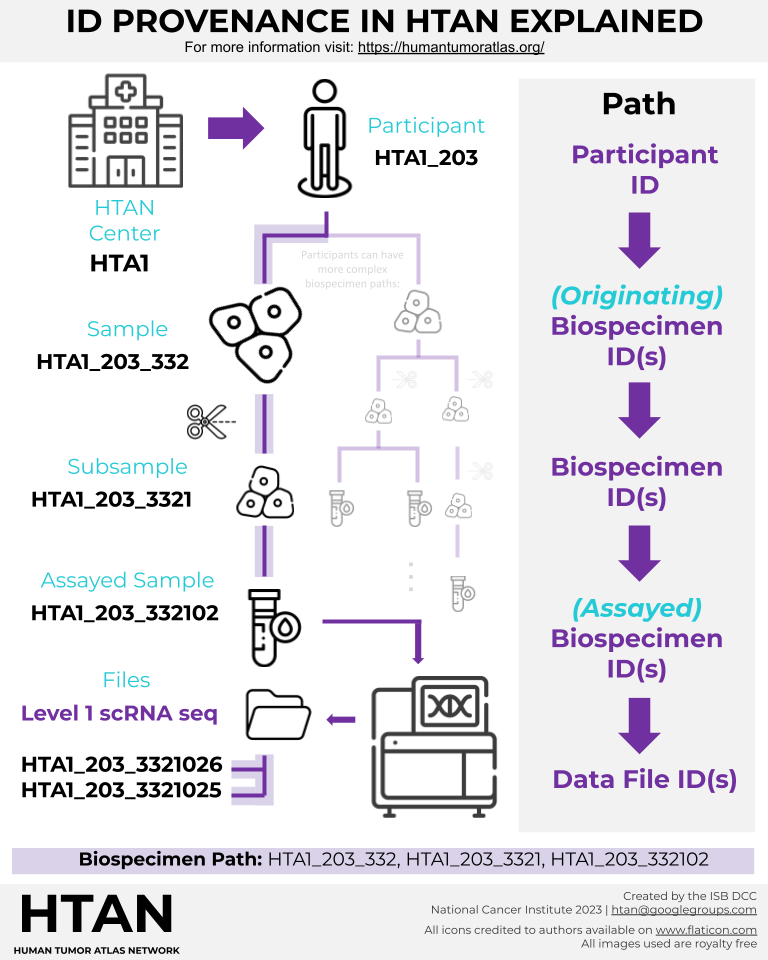

Figure 1. This figure shows the ID Provenance from HTAN center, to participant, down to the file level of assayed biospecimen. The path begins with a participant ID `HTA1_203`. The participant has had a sample collected at HTAN center `HTA1`. Once the sample is collected, it is refered to as a `Biospecimen`. Depending on the stage of processing of the biospecimen, this can be refered to as the `originating` or `assayed biospecimen` (shown on the right-hand side in the flow diagram). In this case, the sample is given an originating biospecimen ID of `HTA1_203_332`. This sample is then subsampled to produce `HTA1_203_3321` and subsequently assayed with scRNA seq to produce files with data file IDs: `HTA1_203_3321026` and `HTA1_203_3321025`. The full Biospecimen path is shown in purple at the bottom of the figure.

## Query for Figure 1

The relationships illustrated in Figure 1 can be represented in tabular format via the query below. 

The resulting table lists all single cell RNA-seq files derived from the assayed biospecimen `HTA1_203_332102` along with participant, biospecimen, and path relationships.  Although Figure 1 only shows the files at the scRNA-seq level 1 stage, we see from the table that this assayed biospecimen went on to additional stages of processing. 




In [3]:
fig_1 = client.query("""
    SELECT DISTINCT 
      HTAN_Center, 
      Component,  
      HTAN_Data_File_ID, 
      HTAN_Assayed_Biospecimen_ID, 
      HTAN_Originating_Biospecimen_ID,
      HTAN_Participant_ID,
      Biospecimen_Path, 
      (LENGTH(Biospecimen_Path) - LENGTH(REPLACE(Biospecimen_Path,",",""))+1) AS PathLength
    FROM `isb-cgc-bq.HTAN.id_provenance_current` 
    WHERE HTAN_Assayed_Biospecimen_ID = 'HTA1_203_332102'
    """).result().to_dataframe()

In [4]:
fig_1

,HTAN_Center,Component,HTAN_Data_File_ID,HTAN_Assayed_Biospecimen_ID,HTAN_Originating_Biospecimen_ID,HTAN_Participant_ID,Biospecimen_Path,PathLength
0,HTAN HTAPP,ScRNA-seqLevel1,HTA1_203_3321025,HTA1_203_332102,HTA1_203_332,HTA1_203,"HTA1_203_332,HTA1_203_3321,HTA1_203_332102",3
1,HTAN HTAPP,ScRNA-seqLevel2,HTA1_203_332102501,HTA1_203_332102,HTA1_203_332,HTA1_203,"HTA1_203_332,HTA1_203_3321,HTA1_203_332102",3
2,HTAN HTAPP,ScRNA-seqLevel3,HTA1_203_3321025011,HTA1_203_332102,HTA1_203_332,HTA1_203,"HTA1_203_332,HTA1_203_3321,HTA1_203_332102",3
3,HTAN HTAPP,ScRNA-seqLevel4,HTA1_203_33210250111,HTA1_203_332102,HTA1_203_332,HTA1_203,"HTA1_203_332,HTA1_203_3321,HTA1_203_332102",3
4,HTAN HTAPP,ScRNA-seqLevel3,HTA1_203_3321025012,HTA1_203_332102,HTA1_203_332,HTA1_203,"HTA1_203_332,HTA1_203_3321,HTA1_203_332102",3
5,HTAN HTAPP,ScRNA-seqLevel3,HTA1_203_3321025013,HTA1_203_332102,HTA1_203_332,HTA1_203,"HTA1_203_332,HTA1_203_3321,HTA1_203_332102",3
6,HTAN HTAPP,ScRNA-seqLevel1,HTA1_203_3321026,HTA1_203_332102,HTA1_203_332,HTA1_203,"HTA1_203_332,HTA1_203_3321,HTA1_203_332102",3


## 4.2 Table Construction 

As illustrated in Figure 1 above, biospecimens can be subsampled multiple times. However, HTAN metadata tables provide only the immediate parent biospecimen. To assemble the full biospecimen path, we perform a series of joins on the biospecimen table, walking up the parent biospecimen ancestry chain until no further parents are found. 

Similarly, we can have up to four data file ‘levels’. Each data file is linked using its provided parent HTAN data file ID(s). 

We then join biospecimen information with file-level annotations to form the final ID provenance table.

## 4.3 Table Structure

In addition to upstream biospecimen and participant IDs, the provenance table also includes a number of informational columns, such as `entityId` (Synapse ID of the source file), `HTAN_Center` (text version of center code), and `Data_Release` and `GC_Release` which indicate which HTAN Portal release and General Commons (GC) release the file was included in, respectively.

In [6]:
q1 = client.query("""
  SELECT table_name,column_name FROM
  `isb-cgc-bq.HTAN.INFORMATION_SCHEMA.COLUMNS`
  WHERE table_name = 'id_provenance_current'
  """).result().to_dataframe()

q1

,table_name,column_name
0,id_provenance_current,HTAN_Data_File_ID
1,id_provenance_current,Filename
2,id_provenance_current,entityId
3,id_provenance_current,Component
4,id_provenance_current,Data_Release
5,id_provenance_current,HTAN_Center
6,id_provenance_current,HTAN_Assayed_Biospecimen_ID
7,id_provenance_current,HTAN_Parent_Data_File_ID
8,id_provenance_current,HTAN_Originating_Biospecimen_ID
9,id_provenance_current,HTAN_Participant_ID



The provenance table contains identifier information for each annotated data file, however, the table does not strictly contain only one row per file. 

In the example below, we select for a single Bulk WES Level 2 data file, `HTA9_1_19577`, which was derived from 8 Bulk WES Level 1 data files. In such cases, the file is represented in the provenance table as a separate row per parent file ID. 






In [7]:
q2 = client.query("""
    SELECT DISTINCT 
      HTAN_Data_File_ID,
      HTAN_Parent_Data_File_ID,
      Component,
      entityId,
      HTAN_Center
    FROM `isb-cgc-bq.HTAN.id_provenance_current`
    where HTAN_Data_File_ID="HTA9_1_19577"
    """).result().to_dataframe()

q2

,HTAN_Data_File_ID,HTAN_Parent_Data_File_ID,Component,entityId,HTAN_Center
0,HTA9_1_19577,HTA9_1_19547,BulkWESLevel2,syn26537495,HTAN OHSU
1,HTA9_1_19577,HTA9_1_19540,BulkWESLevel2,syn26537495,HTAN OHSU
2,HTA9_1_19577,HTA9_1_19528,BulkWESLevel2,syn26537495,HTAN OHSU
3,HTA9_1_19577,HTA9_1_19564,BulkWESLevel2,syn26537495,HTAN OHSU
4,HTA9_1_19577,HTA9_1_19537,BulkWESLevel2,syn26537495,HTAN OHSU
5,HTA9_1_19577,HTA9_1_19560,BulkWESLevel2,syn26537495,HTAN OHSU
6,HTA9_1_19577,HTA9_1_19519,BulkWESLevel2,syn26537495,HTAN OHSU
7,HTA9_1_19577,HTA9_1_19549,BulkWESLevel2,syn26537495,HTAN OHSU


# 5. Explore The ID Provenance Table in Google BigQuery

In this section we'll showcase how the ID provenance table can be used to answer different questions pertaining to HTAN data files and their upstream biospecimen and participant IDs.


### 5.1 EXAMPLE 1

As a data submitter, you may want to know how many of your center's submitted files have been released on the HTAN Data Portal, and which are available on the GC via SB-CGC. 

In [9]:
example_1 = client.query("""
  SELECT Component,Data_Release,GC_Release,Count(*) AS Count
  FROM `isb-cgc-bq.HTAN.id_provenance_current` 
  WHERE HTAN_Center = 'HTAN OHSU'
  GROUP BY Component,Data_Release,GC_Release
  ORDER BY Component
  """).result().to_dataframe()

example_1

,Component,Data_Release,GC_Release,Count
0,BulkRNA-seqLevel1,Release 4.0,v23.10.1.seq,52
1,BulkRNA-seqLevel1,Release 1.0,v22.12.1.seq,8
2,BulkRNA-seqLevel1,Release 3.0,v22.12.1.seq,28
3,BulkRNA-seqLevel2,Release 4.0,v23.10.1.seq,52
4,BulkRNA-seqLevel2,Release 2.0,v22.6.1.seq,4
5,BulkRNA-seqLevel3,Release 4.0,None,26
6,BulkRNA-seqLevel3,Release 2.0,None,12
7,BulkWESLevel1,Release 5.0,v24.8.1.seq,98
8,BulkWESLevel1,Release 1.0,v21.9.1.seq,126
9,BulkWESLevel1,Release 3.0,v22.12.1.seq,94


The resulting table tells you how many files, by assay type and level, were included in which major HTAN Data Release and GC package.

### 5.2 EXAMPLE 2

QUESTION: Which patients have both scRNAseq and imaging data available?

ANSWER:

In [10]:
example_2 = client.query("""
    WITH img AS (
      SELECT Component,HTAN_Participant_ID 
      FROM `isb-cgc-bq.HTAN.id_provenance_current`
      WHERE Component = 'ImagingLevel2'
    ),
    seq AS (
      SELECT Component,HTAN_Participant_ID 
      FROM `isb-cgc-bq.HTAN.id_provenance_current`
      WHERE Component = 'ScRNA-seqLevel1'
    ),
    j1 AS (
      SELECT * from img
      JOIN seq
      USING(HTAN_Participant_ID)
    )
    SELECT DISTINCT HTAN_Participant_ID from j1
    """).result().to_dataframe()

In [11]:
example_2

,HTAN_Participant_ID
0,HTA10_01
1,HTA10_02
2,HTA10_03
3,HTA10_04
4,HTA10_05
...,...
151,HTA8_6023
152,HTA8_6024
153,HTA8_6025
154,HTA8_6027


The resulting table provides a list of HTAN participants for which single cell level 1 fastq files and imaging files have been submitted.


### 5.3 EXAMPLE 3

QUESTION: Can I get the number of annotated files per assay type generated for a specific patient in HTAN? For example, patient `HTA9_1`?

ANSWER:

In [12]:
example_3 = client.query("""
    SELECT Component,Count(*) as Count
    FROM `isb-cgc-bq.HTAN.id_provenance_current`
    WHERE HTAN_Participant_ID = 'HTA9_1'
    GROUP BY Component
    """).result().to_dataframe()

In [13]:
example_3

,Component,Count
0,BulkWESLevel1,214
1,BulkRNA-seqLevel1,16
2,ImagingLevel2,77
3,BulkWESLevel2,76
4,BulkWESLevel3,23
5,BulkRNA-seqLevel3,13
6,ImagingLevel3Segmentation,67
7,ImagingLevel4,12
8,ElectronMicroscopyLevel1,15496
9,ElectronMicroscopyLevel2,14351


In this example, the output provided is the number of annotated files for each specific patient across all the assays available in HTAN. This individual has data associated with RNA/WES sequencing, Imaging, etc.

### 5.4 EXAMPLE 4

Visium sequencing is a method of spatial gene expression profiling created by [10X genomics](https://www.10xgenomics.com/products/spatial-gene-expression?utm_medium=search&utm_medium=search&utm_source=google&utm_source=google&utm_campaign=sem-goog-2022-website-page-ra_g-p_visium-brand-platform&utm_campaign=sem-goog-2022-website-page-ra_g-p_visium-brand-platform&useroffertype=quote-request&useroffertype=quote-request&userresearcharea=ra_g&userresearcharea=ra_g&userregion=multi&userregion=multi&userrecipient=customer&userrecipient=customer&usercampaignid=7011P0000013tOjQAI&usercampaignid=7011P0000013tOjQAI&gad=1&gclid=CjwKCAjwpuajBhBpEiwA_ZtfhZl1GH9KkZyO1-hcF-suaUG-XVOw3dxm5G3n7dc0YXppzoymsj1hnxoCWWMQAvD_BwE). Currently, the HTAN DCC is in the process of releasing this data type for public use.

As with other sequencing methods, the Visium pipeline relies on several key inputs such as FASTQ files and TIF images. In order to recreate the analysis, all of the pieces need to be collated and fed into the pipeline. To do this, the following example shows a snipet of how this data can be collated.



QUESTION: Can I pull all of the files associated with a specific assay pipeline? For example, can I pull all Visium files associated with sample `HTA12_33_1`?

ANSWER:

In [14]:
example_4 = client.query("""
    SELECT  *
    FROM `isb-cgc-bq.HTAN.id_provenance_current`
    WHERE HTAN_Assayed_Biospecimen_ID = 'HTA12_33_1' AND
    Component LIKE '%Visium%'
    """).result().to_dataframe()

In [15]:
example_4

,HTAN_Data_File_ID,Filename,entityId,Component,Data_Release,HTAN_Center,HTAN_Assayed_Biospecimen_ID,HTAN_Parent_Data_File_ID,HTAN_Originating_Biospecimen_ID,HTAN_Participant_ID,Biospecimen_Path,GC_Release
0,HTA12_33_1001,visium_level_1-ccrcc23/TWCE-HT282N1-S1H3Fs4U1B...,syn50917844,10xVisiumSpatialTranscriptomics-RNA-seqLevel1,Release 3.0,HTAN WUSTL,HTA12_33_1,None,HTA12_33_1,HTA12_33,HTA12_33_1,v22.12.1.seq
1,HTA12_33_1002,visium_level_1-ccrcc23/TWCE-HT282N1-S1H3Fs4U1B...,syn50917852,10xVisiumSpatialTranscriptomics-RNA-seqLevel1,Release 3.0,HTAN WUSTL,HTA12_33_1,None,HTA12_33_1,HTA12_33,HTA12_33_1,v22.12.1.seq
2,HTA12_33_1003,visium_auxiliary_ccrcc23/C1_HT282N1-S1H3Fs4U1.tif,syn51283222,10xVisiumSpatialTranscriptomics-AuxiliaryFiles,Release 3.0,HTAN WUSTL,HTA12_33_1,Not Applicable,HTA12_33_1,HTA12_33,HTA12_33_1,None
3,HTA12_33_2001,visium_level_2_ccrcc23_bam/HT282N1-S1H3Fs4U1Bp...,syn51202923,10xVisiumSpatialTranscriptomics-RNA-seqLevel2,Release 3.0,HTAN WUSTL,HTA12_33_1,HTA12_33_1001,HTA12_33_1,HTA12_33,HTA12_33_1,v23.7.1.seq
4,HTA12_33_2001,visium_level_2_ccrcc23_bam/HT282N1-S1H3Fs4U1Bp...,syn51202923,10xVisiumSpatialTranscriptomics-RNA-seqLevel2,Release 3.0,HTAN WUSTL,HTA12_33_1,HTA12_33_1002,HTA12_33_1,HTA12_33,HTA12_33_1,v23.7.1.seq
5,HTA12_33_3001,visium_level_3_ccrcc23/HT282N1-S1H3Fs4U1Bp1_ba...,syn51202902,10xVisiumSpatialTranscriptomics-RNA-seqLevel3,Release 3.0,HTAN WUSTL,HTA12_33_1,HTA12_33_2001,HTA12_33_1,HTA12_33,HTA12_33_1,None
6,HTA12_33_3002,visium_level_3_ccrcc23/HT282N1-S1H3Fs4U1Bp1_fe...,syn51202903,10xVisiumSpatialTranscriptomics-RNA-seqLevel3,Release 3.0,HTAN WUSTL,HTA12_33_1,HTA12_33_2001,HTA12_33_1,HTA12_33,HTA12_33_1,None
7,HTA12_33_3003,visium_level_3_ccrcc23/HT282N1-S1H3Fs4U1Bp1_ma...,syn51202905,10xVisiumSpatialTranscriptomics-RNA-seqLevel3,Release 3.0,HTAN WUSTL,HTA12_33_1,HTA12_33_2001,HTA12_33_1,HTA12_33,HTA12_33_1,None
8,HTA12_33_3004,visium_auxiliary_ccrcc23/HT282N1-S1H3Fs4U1Bp1_...,syn51283225,10xVisiumSpatialTranscriptomics-AuxiliaryFiles,Release 3.0,HTAN WUSTL,HTA12_33_1,HTA12_33_2001,HTA12_33_1,HTA12_33,HTA12_33_1,None
9,HTA12_33_3005,visium_auxiliary_ccrcc23/HT282N1-S1H3Fs4U1Bp1_...,syn51283223,10xVisiumSpatialTranscriptomics-AuxiliaryFiles,Release 3.0,HTAN WUSTL,HTA12_33_1,HTA12_33_2001,HTA12_33_1,HTA12_33,HTA12_33_1,None


In this table, we are provided with all the information pertaining to the inputs and outputs of a single run associated with a visium experiment. In this case, the "run" in visium refers to a single capture area with a unique biospecimen (segment) on a unique slide. This run shows all the files used to run the space ranger pipeline (fastq + TIF files) along with the corresponding outputs (matricies, features, json scales, etc.)

# 6. Relevant Citations and Links

[The Missing Manual: ID Provenance in HTAN](https://docs.humantumoratlas.org/data_model/relationships/)


[HTAN Portal](https://humantumoratlas.org/)



If you have further interest in exploring open access data available in BigQuery in conjunction with controlled access data in SB-CGC, please refer to our other notebook:

[Integrating Controlled and Open Access 10X Visium Data in SB-CGC Data Studio](https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/Analyzing_HTAN_Data_in_SB_Data_Studio.ipynb)